# Introduction

During the 2016 US Presidential debate on October 9, 2016 between Hillary Clinton and Donald Trump, we maintained a connection to Twitter's public streaming API and tracked the following terms:
* Hillary
* Clinton
* Trump
* @HillaryClinton
* @realDonaldTrump
* #debates

We collected 455,464 responses, of which 420,432 were tweets and 35,032 were rate limit responses. The rate limit responses represented 2,031,540 tweets.

## Spark + Jupyter

We're using Python 2.7 in an Anaconda environment. PySpark is instructed to use the environment's kernel and to launch the Jupyter notebook contained within the environment. Spark runs in local mode with a memory executor cap of 44GB.

## Python Imports

All imports for this notebook are included in this first input box. Many objects are persisted between boxes, so one will find it easiest to run this notebook by executing all boxes top-to-bottom.

In [279]:
from __future__ import print_function

# Standard Python imports
import datetime
import time
import string
import json

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import warnings # current version of seaborns generates warnings
warnings.filterwarnings("ignore")
import seaborn as sns

# Pandas
import pandas as pd

# SparkSQL functions and types
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
 
# Natural language processing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Machine learning
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import NaiveBayes

## Load the Data into Spark and Make it SQL-able

In [280]:
data_dir = '/data/md0/anaconda/debate'
df = sqlContext.read.json(data_dir)
df.count()

455464

The temp table will be called 'tweets'.

In [281]:
df.registerTempTable('tweets')

What does the schema of a tweet on the streaming API look like?

In [260]:
df.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |

## How many Responses are Tweets?

In [261]:
query = """
select count(*) from tweets where text is not null
"""
sqlContext.sql(query).show()

+------+
|   _c0|
+------+
|420432|
+------+



## Rate Limit Responses

Let's determine how many rate limit responses we received. These are responses of the form:
```
{"limit":{"track":116598,"timestamp_ms":"1476061861869"}}
```
where `timestamp_ms` represents the millisecond timestamp when the response was sent and `track` represents the total number of tweets missed since the current stream connection was established.

First, let's determine how many rate limit responses were received.

In [282]:
# Form a dataframe that only contains the rate limit responses
rate_limits_df = df.select(
    df['limit']['track'].alias('track'),
    df['limit']['timestamp_ms'].cast('long').alias('timestamp_ms'))
rate_limits_df = rate_limits_df.filter(rate_limits_df['track'] > 0)

# Register as a temp table
rate_limits_df.registerTempTable('ratelimits')

# How many rate limit responses were received?
query = "select count(*) as num from ratelimits"

# Run query and show results
sqlContext.sql(query).show()

+-----+
|  num|
+-----+
|35032|
+-----+



Let's see how our rate limit increased with respect to time. We'll take the maximum track value by minute since the debate started and graph the results. As a side note, local time in MST.

In [263]:
# What was the unix time when the debate started?
d = datetime.datetime(year=2016, month=10, day=9, hour=19, minute=0)
debate_start_time = long(time.mktime(d.timetuple()))

query = """
select
    max(a.track) as track,
    a.minute as minute
from (
    select
        floor(track/1000) as track,
        floor(floor((timestamp_ms/1000)-%s)/60) as minute
    from ratelimits ) a
group by minute
order by minute
""" % debate_start_time

limit_by_minute_pdf = sqlContext.sql(query).toPandas()

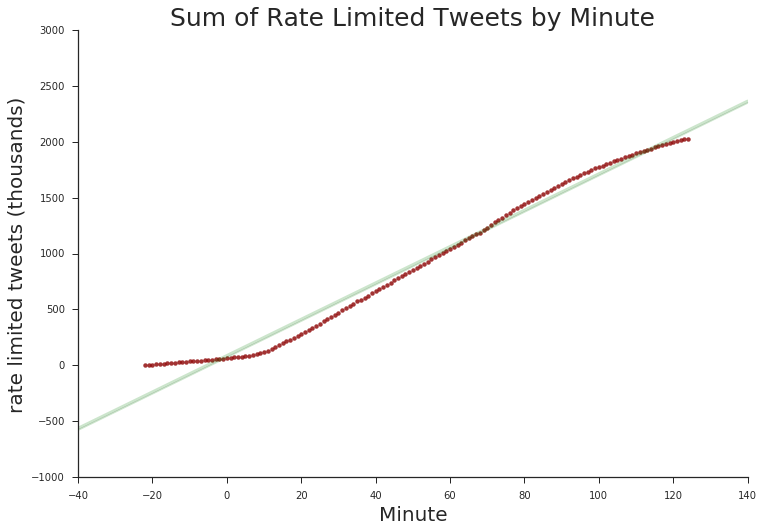

In [278]:
g = sns.regplot(x="minute", y="track", data=limit_by_minute_pdf, ci = False, 
    scatter_kws={"color":"darkred","alpha":0.8,"s":20},
    line_kws={"color":"g","alpha":0.2,"lw":4},marker="o")
sns.despine()
g.figure.set_size_inches(12,8)
g.axes.set_title('Sum of Rate Limited Tweets by Minute', fontsize=25)
g.set_xlabel("Minute", size=20)
g.set_ylabel("rate limited tweets (thousands)", size=20)

The graph above can be used when doing a time series analysis of streaming Twitter data, as the rate limit responses are based on the total tweets not delivered since the beginning of the stream connection. As a result, if one were to compute tweets per minute and consider rate limit responses, one must be aware of dropped and reconnected streams, as the track counter will reset.

Since our counter did not reset, we know that the total number of missed tweets is the maximum track value found in the rate limit responses. So, how many tweets did we miss?

In [265]:
query = """
select max(track) from ratelimits
"""
sqlContext.sql(query).show()

+-------+
|    _c0|
+-------+
|2031540|
+-------+



## How Many (Collected) Tweets Mentioned Each Candidate

We'll write a query to determine whether a tweet mentioned only Hillary, only Trump, both Hillary and Trump, or neither. We'll then graph this using a Pandas dataframe and Seaborn.

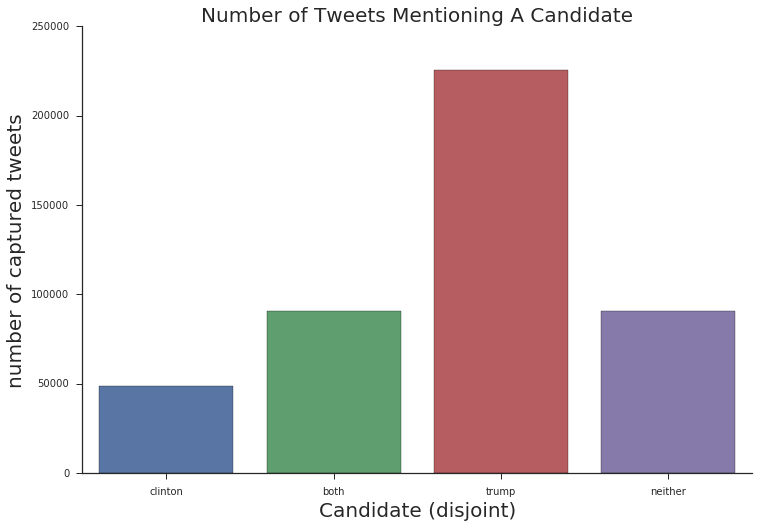

In [283]:
# Form the query
query = """
select
    case
        when a.mentions_clinton = 1 and a.mentions_trump = 1 then 'both'
        when a.mentions_clinton = 1 then 'clinton'
        when a.mentions_trump = 1 then 'trump'
        else 'neither'
    end as candidate
from (
    select
        text,
        case
            when lower(text) like '%hillary%' then 1
            when lower(text) like '%clinton%' then 1
            else 0
        end as mentions_clinton,
        case
            when lower(text) like '%donald%' then 1
            when lower(text) like '%trump%' then 1
            else 0
        end as mentions_trump
    from tweets ) a
"""
# Execute the query and store as a Pandas dataframe
dfp = sqlContext.sql(query).toPandas()

# Form the Seaborn plot
g = sns.countplot(x='candidate', data=dfp)
sns.despine()
g.figure.set_size_inches(12,8)
g.axes.set_title('Number of Tweets Mentioning A Candidate', fontsize=20)
g.set_xlabel("Candidate (disjoint)", size=20)
g.set_ylabel("number of captured tweets", size=20)

## Most Common Devices for Candidate Mentions

When people were tweeting explicitly about Trump or Hillary (or both), which devices were they using?

In [324]:
query = """
select
    b.source as source,
    b.candidate as candidate,
    count(*) as num
from (
    select
        a.source as source,
        case
            when a.mentions_clinton = 1 and a.mentions_trump = 1 then 'both'
            when a.mentions_clinton = 1 then 'clinton'
            when a.mentions_trump = 1 then 'trump'
            else 'neither'
        end as candidate
    from (
        select
            source as sourceOrig,
            case
                when lower(text) like '%hillary%' then 1
                when lower(text) like '%clinton%' then 1
                else 0
            end as mentions_clinton,
            case
                when lower(text) like '%donald%' then 1
                when lower(text) like '%trump%' then 1
                else 0
            end as mentions_trump,
            case
                when lower(source) like '%iphone%' then 'iPhone'
                when lower(source) like '%ipad%' then 'iPad'
                when lower(source) like '%android%' then 'Android'
                when lower(source) like '%web client%' then 'Web Client'
                when lower(source) like '%mobile web%' then 'Mobile Web'
                when lower(source) like '%ifttt%' then 'IFTTT'
                when lower(source) like '%twitterfeed%' then 'Twitterfeed'
                when lower(source) like '%facebook%' then 'Facebook'
                when lower(source) like '%tweetdeck%' then 'Tweetdeck'
                when lower(source) like '%twitter for windows%' then 'Twitter for Windows'
                when lower(source) like '%twitter for mac%' then 'Twitter for Mac'
                when lower(source) like '%tweetbot%' then 'Tweetbot'
                else 'unknown'
            end as source
        from tweets 
        where source is not Null and text is not Null) a
    where a.source != 'unknown' and (a.mentions_trump = 1 or a.mentions_clinton = 1)) b
group by b.source, b.candidate
order by num desc
limit 20
"""
dfp = sqlContext.sql(query).toPandas()

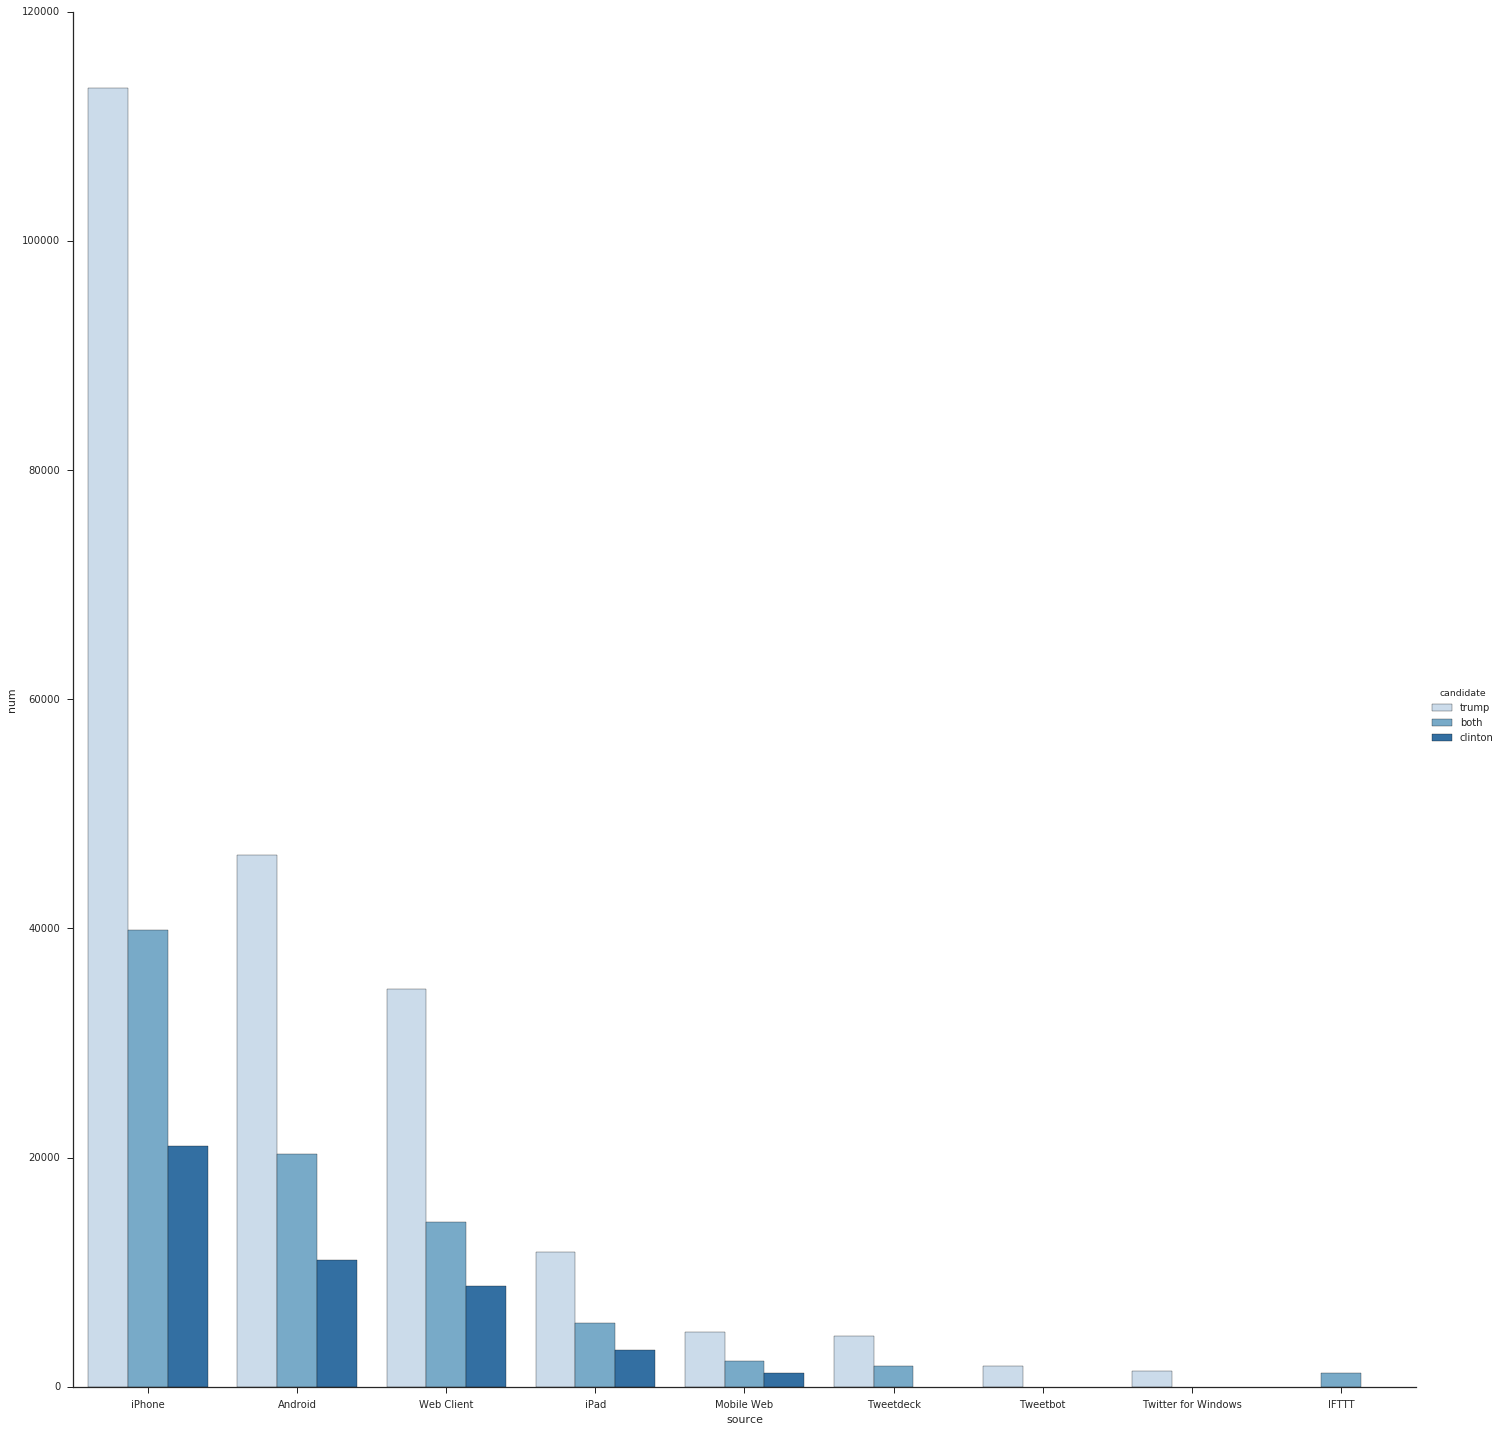

In [335]:
g = sns.factorplot("source","num", data=dfp, kind="bar", hue="candidate", palette="Blues", size=20)

In [330]:
sns.factorplot?

## Language Analysis

Can we predict which candidate a user is tweeting about based on the language they use? Let's form a new dataframe containing only the tweet text and the candidate as a category/label where:
* 0=Clinton
* 1=both
* 2=Trump
* 3=neither

In [267]:
# Form a query to return only english tweets: text and classify the candidate(s) as
#  0 only clinton
#  1 clinton and trump
#  2 only trump
#  3 neither
query = """
select
    case
        when a.mentions_clinton = 1 and a.mentions_trump = 1 then 1
        when a.mentions_clinton = 1 then 0
        when a.mentions_trump = 1 then 2
        else 3
    end as label,
    a.text as text
from (
    select
        case
            when lower(text) like '%hillary%' then 1
            when lower(text) like '%clinton%' then 1
            else 0
        end as mentions_clinton,
        case
            when lower(text) like '%donald%' then 1
            when lower(text) like '%trump%' then 1
            else 0
        end as mentions_trump,
        lower(text) as text
    from tweets
    where text is not null and lang = 'en') a
"""
# Get a dataframe of results
df2 = sqlContext.sql(query)

# Turn the dataframe into a Spark RDD
rdd = df2.rdd.map(tuple)

# How many tweets do we have in our RDD?
rdd.count()

397170

#### Cleaning the Tweet Texts

We want to remove any reference to the candidates included in the text of the tweet, as not doing so would provide a direct correlation to the candidate label.

In [268]:
# Define the function
def remove_candidates(text):
    return (text.replace('@hillaryclinton','')
        .replace('@realdonaldtrump','')
        .replace('hillary','')
        .replace('clinton','')
        .replace('donald','')
        .replace('trump',''))

# Apply the function and create a new RDD
rdd2 = rdd.map(lambda (label, text): (label, remove_candidates(text)))

# Show a few rows for reference
rdd2.take(3)

[(0, u'judicial watch update on  scandal https://t.co/ev2hbu3qe4..'),
 (1,
  u'rt @janet_press: second presidential debate   vs  \n\nlive stream: fast link:\n\nhttps://t.co/xzum84slmq\n\n#debate'),
 (0,
  u'rt @kathyshelton_: when i can\u2019t sleep i wish i could make   answer me: would you have done to your daughter what you did to m\u2026')]

#### Natural Language Processing

We now have a Spark RDD containing only the tweet text and candidate label. We need to do some cleaning on the text.

In [269]:
# Module-level global variables for the `tokenize` function below
PUNCTUATION = set(string.punctuation)
STOPWORDS = set(stopwords.words('english'))
STEMMER = PorterStemmer()

# Function to break text into "tokens", lowercase them, remove punctuation and stopwords, and stem them
def tokenize(text):
    tokens = word_tokenize(text)
    no_punctuation = []
    for word in tokens:
        punct_removed = ''.join([letter for letter in word if not letter in PUNCTUATION])
        no_punctuation.append(punct_removed)
    no_stopwords = [w for w in no_punctuation if not w in STOPWORDS]
    stemmed = [STEMMER.stem(w) for w in no_stopwords]
    return [w for w in stemmed if w]

# tokenize/clean the data
rdd_cleaned = rdd2.map(lambda (label, text): (label, tokenize(text)))
rdd_cleaned.take(3)

[(0, [u'judici', u'watch', u'updat', u'scandal', u'http', u'tcoev2hbu3qe4']),
 (1,
  [u'rt',
   u'janetpress',
   u'second',
   u'presidenti',
   u'debat',
   u'vs',
   u'live',
   u'stream',
   u'fast',
   u'link',
   u'http',
   u'tcoxzum84slmq',
   u'debat']),
 (0,
  [u'rt',
   u'kathyshelton',
   u'can\u2019t',
   u'sleep',
   u'wish',
   u'could',
   u'make',
   u'answer',
   u'would',
   u'done',
   u'daughter',
   u'm\u2026'])]

We need to convert each list of words into a hashed frequency vector. The `HashingTF` function from the MLlib feature library will do this automatically.

In [270]:
# Hashing term frequency vectorizer with 50k features
htf = HashingTF(50000)

# Create an RDD of LabeledPoints using category labels as labels and tokenized, hashed text as feature vectors
data_hashed = rdd_cleaned.map(lambda (label, text): (label, htf.transform(text)))
data_hashed.take(3)

[(0,
  SparseVector(50000, {11295: 1.0, 13332: 1.0, 19140: 1.0, 20489: 1.0, 32172: 1.0, 44604: 1.0})),
 (1,
  SparseVector(50000, {5714: 1.0, 5748: 1.0, 8879: 2.0, 10692: 1.0, 13332: 1.0, 15090: 1.0, 16558: 1.0, 18403: 1.0, 19318: 1.0, 31616: 1.0, 34247: 1.0, 36211: 1.0})),
 (0,
  SparseVector(50000, {1258: 1.0, 10585: 1.0, 12756: 1.0, 17731: 1.0, 19524: 1.0, 19992: 1.0, 24624: 1.0, 28906: 1.0, 29588: 1.0, 31616: 1.0, 39342: 1.0, 42630: 1.0}))]

We now convert each row to a LabeledPoint, which is a data structure required for MLlib's NaiveBayes model system.

In [271]:
data_labeled = data_hashed.map(lambda (label, text): (LabeledPoint(label, text)))
data_labeled.take(3)

[LabeledPoint(0.0, (50000,[11295,13332,19140,20489,32172,44604],[1.0,1.0,1.0,1.0,1.0,1.0])),
 LabeledPoint(1.0, (50000,[5714,5748,8879,10692,13332,15090,16558,18403,19318,31616,34247,36211],[1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])),
 LabeledPoint(0.0, (50000,[1258,10585,12756,17731,19524,19992,24624,28906,29588,31616,39342,42630],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]

Split the LabeledPoint RDD into a training and test set. We'll run our machine learning algorithm on the training set and then test it on the test set to see how well it performs. Our data_labeled RDD already has a method which makes this available.

In [272]:
# Split data 70/30 into training and test data sets
training, test = data_labeled.randomSplit([0.7, 0.3], seed=0)

We now train our Naive Bayes model.

In [273]:
# Train a Naive Bayes model on the training data
start_time = time.time()
model = NaiveBayes.train(training, 1.0)
elapsed_time = int(time.time() - start_time)

print("model generated in %s seconds" % elapsed_time)

model generated in 34 seconds


Now, we can generate predictions for our test set based off the model.

In [274]:
# Compare predicted labels to actual labels
prediction_and_labels = test.map(lambda p: (model.predict(p.features), p.label))

How accurate is the model on the test set?

In [275]:
accuracy = 1.0 * prediction_and_labels.filter(lambda (x, v): x == v).count() / test.count()
print("test set accuracy: %s" % round(accuracy*100,2))

test set accuracy: 73.08


### Limiting Language to Specific Candidates

What happens if we perform the same analysis, but this time only include tweets that specifically mention a single candidate?

In [276]:
# Form a query to return only english tweets: text and classify the candidate(s) as
#  0 only clinton
#  1 clinton and trump
#  2 only trump
#  3 neither
query = """
select
    case
        when a.mentions_clinton = 1 and a.mentions_trump = 1 then 1
        when a.mentions_clinton = 1 then 0
        when a.mentions_trump = 1 then 2
        else 3
    end as label,
    a.text as text
from (
    select
        case
            when lower(text) like '%hillary%' then 1
            when lower(text) like '%clinton%' then 1
            else 0
        end as mentions_clinton,
        case
            when lower(text) like '%donald%' then 1
            when lower(text) like '%trump%' then 1
            else 0
        end as mentions_trump,
        lower(text) as text
    from tweets
    where text is not null and lang = 'en') a
where a.mentions_clinton != a.mentions_trump
"""
# Get a dataframe of results
df2 = sqlContext.sql(query)

# Turn the dataframe into a Spark RDD
rdd = df2.rdd.map(tuple)

# Apply the function and create a new RDD
rdd2 = rdd.map(lambda (label, text): (label, remove_candidates(text)))

# tokenize/clean the data
rdd_cleaned = rdd2.map(lambda (label, text): (label, tokenize(text)))

# Hashing term frequency vectorizer with 50k features
htf = HashingTF(50000)

# Create an RDD of LabeledPoints using category labels as labels and tokenized, hashed text as feature vectors
data_hashed = rdd_cleaned.map(lambda (label, text): (label, htf.transform(text)))

# Create labeled point RDD
data_labeled = data_hashed.map(lambda (label, text): (LabeledPoint(label, text)))

# Split data 70/30 into training and test data sets
training, test = data_labeled.randomSplit([0.7, 0.3], seed=0)

# Train a Naive Bayes model on the training data
model = NaiveBayes.train(training, 1.0)

# Compare predicted labels to actual labels
prediction_and_labels = test.map(lambda p: (model.predict(p.features), p.label))

accuracy = 1.0 * prediction_and_labels.filter(lambda (x, v): x == v).count() / test.count()
print("test set accuracy: %s" % round(accuracy*100,2))

test set accuracy: 89.25
